# Scraping the top 30 GitHub repositories 







Here are the steps we'll follow:
- We're going to scrap https://github.com/topics
- We'll get a list of topics. For each topic, we'll get topic title, topic page URL and topic description
- For each topic we'll get top 25 repos from the topic page.
- For each repo we'll have the repo name, username, stars and repo URL
- For each topic we'll have a CSV file.

Let's get started.

## Scrape the list of topics from GitHub

Steps:

- use requests to download the page
- use BS4 to parse extracted
- convert it into a pandas dataframe

Let's write a function to download the page.



In [25]:
import pandas as pd

In [26]:
#!pip install requests
import requests
from bs4 import BeautifulSoup

def get_topics_page():
    # This function gets the topic's web-page link and then downloads pages' content, parse it and returns the parsed information
    topic_page_url = 'https://github.com/topics'
    response = requests.get(topic_page_url)
    if response.status_code !=200:
        raise Exception ('Failed to load page {}'.format(topic_page_url))
    doc = BeautifulSoup(response.text, 'html.parser')
    return doc


The doc variable is of type bs4.BeautifulSoup and it has parsed information of web-page.

In [27]:
doc = get_topics_page()

In [28]:
type(doc)

bs4.BeautifulSoup

In this doc we can find the classes and tags that have information we need using the find() function.

In [29]:
doc.find('a')

<a class="px-2 py-4 color-bg-accent-emphasis color-fg-on-emphasis show-on-focus js-skip-to-content" href="#start-of-content">Skip to content</a>

Let's create some helper functions to parse information from  the topics page.

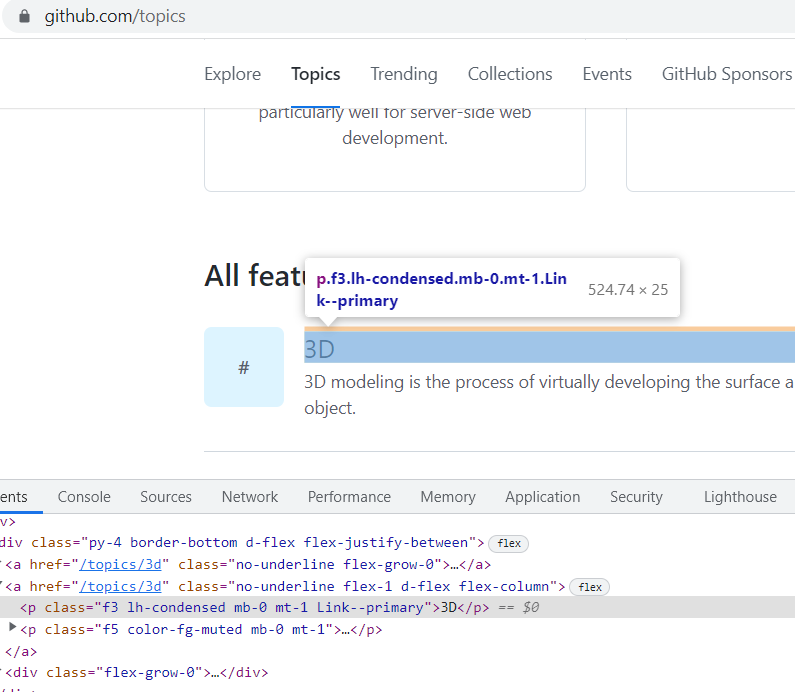

We can see that `p` tag with class `f3 lh-condensed mb-0 mt-1 Link--primary` contains the title `3D`.

So, to get topic titles, we can pick `p` tags with the `class` `f3 lh-condensed mb-0 mt-1 Link--primary`



In [30]:
def get_topic_titles(doc):
    selection_class = 'f3 lh-condensed mb-0 mt-1 Link--primary'
    topic_title_p_tags = doc.find_all('p',{'class' : selection_class}) 
    
    topic_titles = []
    for i in topic_title_p_tags:
        topic_titles.append(i.text)
    return topic_titles


` get_topic_titles ` can be used to get the list of the titles

In [31]:
titles = get_topic_titles(doc)

In [32]:
len(titles)

30

In [33]:
titles[:5]

['3D', 'Ajax', 'Algorithm', 'Amp', 'Android']

similarly, to get the descriptions od topics, we can pick `p` tags with `class` `f5 color-fg-muted mb-0 mt-1` 

Let's define a function named `get_topic_descs()` to get the list of descriptions.

In [34]:

def get_topic_descs(doc):
    selection_class_desc = 'f5 color-fg-muted mb-0 mt-1'
    topic_desc_p_tags = doc.find_all('p',{'class' : selection_class_desc})
    
    topic_desc = []
    for j in topic_desc_p_tags:
        topic_desc.append(j.text.strip())
    return topic_desc


And lastly to get the list of topics' URLs we are gonna define a function named `get_topic_urls()`

In [35]:
def get_topic_urls(doc):
    url_a_tags = doc.find_all('a',{'class' : 'no-underline flex-1 d-flex flex-column'})       
    topic_urls = []
    base_url = 'https://github.com'
    for k in url_a_tags:
        topic_urls.append(base_url + k['href'])
    return topic_urls


Let's put this all together into  a single function

In [36]:
def scrape_topics():
    doc = get_topics_page()
    topics_dict = {
        'title' : get_topic_titles(doc),
        'description' : get_topic_descs(doc),
        'url' : get_topic_urls(doc)
    }
    return pd.DataFrame(topics_dict)


We can now convert this dataframe into CSV if we want to.

## Get the top 30 repos from a topic page.

On the 'Topics' web-page when we click on a topic title, we are redirected to the page that has topic related repositories. We want information about these repos (Name, User name, How many stars a repo has and also the link for repo).


Steps:
- download this page using requests
- parse the information using BS4
- create a function to get the information about a single repo.
- create a function that repeats the above mentioned steps for all the repos and converts the information into a dataframe.

In [37]:
def get_topic_page(topic_page_url):
    #function to get the web-page's content in a doc
    
    # Download the page
    response = requests.get(topic_page_url)
    # Check successful response
    if response.status_code !=200:
        raise Exception ('Failed to load page {}'.format(topic_page_url))
    # Parse using Beautiful Soup
    topic_doc = BeautifulSoup(response.text,'html.parser')
    return topic_doc


In [38]:
doc1 = get_topic_page('https://github.com/topics/3d')

The `h3` tags with class `f3 color-fg-muted text-normal lh-condensed` contain the `a` tags that have information about user-name, repository name and the 

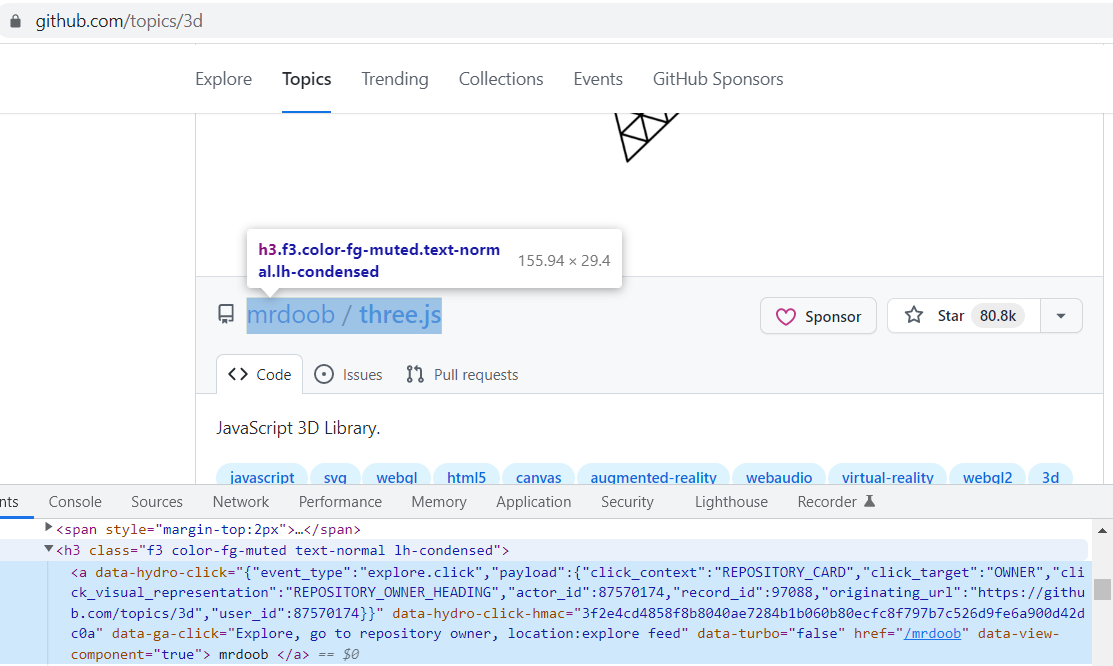

And the `star` tags with class `Counter js-social-count` contain the 

In [39]:
def get_tags():
    # Get the <h3 tags containing repo's title, repo's username, repo's URL:
    h3_selection_class = 'f3 color-fg-muted text-normal lh-condensed'
    repo_h3_tags = doc1.find_all('h3',{'class' : h3_selection_class})
    # Get the <span tags containing repo's stars:
    star_class = 'Counter js-social-count'
    star_span_tags = doc1.find_all('span', {'class' : star_class})
    return repo_h3_tags, star_span_tags

The information about the number of stars a repository has is a string, so we'll change it into integer.

In [40]:
def parse_star_count(stars_str):
    #This function converts the stars information from string type to integer type
    return int(stars_str.replace(',',''))

In [41]:
def get_repo_info(h3_tags, star_tags):
    # returns all the required info about a repository
    base_url = 'https://github.com'
    h3_selection_class = 'f3 color-fg-muted text-normal lh-condensed'
    a_tags = h3_tags.find_all('a')
    user_name = a_tags[0].text.strip()
    repo_name = a_tags[1].text.strip()
    repo_url = base_url + a_tags[1]['href']
    stars = parse_star_count(star_tags)
    return user_name, repo_name, stars, repo_url


In [42]:
repo_h3_tags, star_span_tags = get_tags() 
repo_info = get_repo_info(repo_h3_tags[0], star_span_tags[0]['title'])
print(repo_info)

('mrdoob', 'three.js', 80800, 'https://github.com/mrdoob/three.js')


## Get information about all the repositories in a dataframe

In [43]:
def get_topic_repos(doc1):
    ''' creates and returns a dataframe for the top repos's information '''
    get_tags()
    repo_h3_tags, star_span_tags =  get_tags()
    # Get repo info:
    topic_repos_dict = {'username' : [],
                   'repo_name' : [],
                    'stars' : [],
                    'repo_url' : []
                   } 
    for i in range(len(repo_h3_tags)):
        repo_info = get_repo_info(repo_h3_tags[i],star_span_tags[i]['title'])
        topic_repos_dict['username'].append(repo_info[0])
        topic_repos_dict['repo_name'].append(repo_info[1])
        topic_repos_dict['stars'].append(repo_info[2])
        topic_repos_dict['repo_url'].append(repo_info[3])
    return pd.DataFrame(topic_repos_dict)


In [44]:
repo_df = get_topic_repos(doc1)
repo_df['repo_name'][0:5]

0             three.js
1               libgdx
2    react-three-fiber
3           Babylon.js
4               aframe
Name: repo_name, dtype: object

In [62]:
def scrape_topic(topic_url, path):
    # creating a csv file of information about repositories for a single topic.
    if os.path.exists(path):
        print("The file {} already exists. Skipping...".format(path))
        return
    topic_df = get_topic_repos(get_topic_page(topic_url))
    topic_df.to_csv(path, index = False)


In [64]:
scrape_topic('https://github.com/topics/3d', 'repositories.csv')

The file repositories.csv already exists. Skipping...


## Putting it all together

- We have a function to get a list of topics
- We have a function to create a CSV file for scraped repos from topics page
- Let's create a function to put them together

In [ ]:
import os

In [68]:
def scrape_topics_repos():
    print('Scraping list of topics')
    topics_df = scrape_topics()
    
    # Creating a folder to save csv files in it. 
    os.makedirs('GitHubTopics',exist_ok = True)

    for index, row in topics_df.iterrows():
        print('Scraping top repositories for "{}"'.format(row['title']))
        scrape_topic(row['url'],  'GitHubTopics'+'\\{}.csv'.format(row['title']) )
 

Let's run it to scrape the top repos for all the topics on the first page of github.com/topics

In [69]:
scrape_topics_repos()

Scraping list of topics
Scraping top repositories for "3D"
Scraping top repositories for "Ajax"
Scraping top repositories for "Algorithm"
Scraping top repositories for "Amp"
Scraping top repositories for "Android"
Scraping top repositories for "Angular"
Scraping top repositories for "Ansible"
Scraping top repositories for "API"
Scraping top repositories for "Arduino"
Scraping top repositories for "ASP.NET"
Scraping top repositories for "Atom"
Scraping top repositories for "Awesome Lists"
Scraping top repositories for "Amazon Web Services"
Scraping top repositories for "Azure"
Scraping top repositories for "Babel"
Scraping top repositories for "Bash"
Scraping top repositories for "Bitcoin"
Scraping top repositories for "Bootstrap"
Scraping top repositories for "Bot"
Scraping top repositories for "C"
Scraping top repositories for "Chrome"
Scraping top repositories for "Chrome extension"
Scraping top repositories for "Command line interface"
Scraping top repositories for "Clojure"
Scrapin

We can check that the CSVs were created properly

In [73]:
# read and display CSV using pandas
df = pd.read_csv('GitHubTopics/3D.csv')
df

,username,repo_name,stars,repo_url
0,mrdoob,three.js,80800,https://github.com/mrdoob/three.js
1,libgdx,libgdx,19825,https://github.com/libgdx/libgdx
2,pmndrs,react-three-fiber,17468,https://github.com/pmndrs/react-three-fiber
3,BabylonJS,Babylon.js,16277,https://github.com/BabylonJS/Babylon.js
4,aframevr,aframe,14004,https://github.com/aframevr/aframe
5,ssloy,tinyrenderer,13427,https://github.com/ssloy/tinyrenderer
6,lettier,3d-game-shaders-for-beginners,12570,https://github.com/lettier/3d-game-shaders-for...
7,FreeCAD,FreeCAD,11075,https://github.com/FreeCAD/FreeCAD
8,metafizzy,zdog,9081,https://github.com/metafizzy/zdog
9,CesiumGS,cesium,8484,https://github.com/CesiumGS/cesium


## References and Future Work

Summery of what we did
- We used the BeautifulSoup library for this web-scraping project
- Then we downloaded the web-pages using requests module
- We created function to get the list of topics and thier information(title, description, URL)
- We created function to get the information about all the repositories of a single topic
- lastly, we combined what we did and got the CSV files for each topic's repositories.

References to links I found useful
- https://www.crummy.com/software/BeautifulSoup/bs4/doc/

Ideas for future work
- We can get the information of 'Issues' and 'Pull requests' for each repository as well.
